In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt


class LavenderGrowthEnv:
    def __init__(self):
        self.state = np.array([5000, 25, 60])  # light (lux), temp (°C), humidity (%)
        self.M0 = 5  # initial biomass
        self.M = self.M0
        self.conversion = 0.0185
        self.water_supply = 0.9
        self.stage_factor = 1
        self.red_light = 1 
        self.blue_light = 1
        self.gamma_base = 1.0
        self.rho_base = 0.05
        self.M_max = 1500 * 2

        self.max_days = 90
        self.day = 0

        self.light_range = (3000, 20000)
        self.temp_range = (15, 35)
        self.humidity_range = (30, 80)
        # for reset 
        self.light_reset_range = (7000, 10000)
        self.temp_reset_range = (25, 30)
        self.humidity_reset_range = (50, 60)

        self.action_steps = [-3,-2, -1, 0, 1, 2,3]
        self.action_space = self._generate_actions()
        self.observation_space = len(self.state)

    def _generate_actions(self):
        return [(l, t, h) for l in self.action_steps for t in self.action_steps for h in self.action_steps]

    def step(self, action_index):
        action = self.action_space[action_index]
        for i in range(3):
            self.state[i] += action[i]

        self.state[0] = np.clip(self.state[0], *self.light_range)
        self.state[1] = np.clip(self.state[1], *self.temp_range)
        self.state[2] = np.clip(self.state[2], *self.humidity_range)

        ppfd = self.state[0] * self.conversion
        T = self.state[1]
        water = self.water_supply
        humidity = self.state[2]

        growth = self._plant_growth_rate(self.M, ppfd, T, water, self.stage_factor,
                                         self.red_light, self.blue_light,
                                         self.gamma_base, self.rho_base, self.M_max)

        self.M += growth
        self.day += 1

        done = self.day >= self.max_days
        reward = 0.01 * growth

        return np.array(self.state, dtype=np.float32), reward, done, {}


    def reset(self):
        
        self.state = [
            np.random.randint(self.light_reset_range[0], self.light_reset_range[1] + 1),
            np.random.randint(self.temp_reset_range[0], self.temp_reset_range[1] + 1),
            np.random.randint(self.humidity_reset_range[0], self.humidity_reset_range[1] + 1)
        ]
        self.M = self.M0
        self.day = 0
        return np.array(self.state, dtype=np.float32)

        # ppfd , t , water , m , stage_factor , 
    def _plant_growth_rate(self, M, ppfd, T, water, stage_factor, red_light, blue_light, gamma_base, rho_base, M_max):
        light_factor = (ppfd / (ppfd + 1100)) * (0.7 * red_light + 0.5 * blue_light)
        temp_factor = np.exp(-0.1 * (T - 20) ** 2)
        r = gamma_base * light_factor * temp_factor * water * stage_factor
        respiration = rho_base * (1 + 0.3 * np.cos(ppfd / 1000)) * np.exp(-0.15 * (T - 22)**2)

        growth = (r * (M_max - M) * M / M_max) - respiration
        growth = max(growth, 0)
        return growth
    




In [24]:
env = LavenderGrowthEnv()

alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.999
min_epsilon = 0.05
num_episodes = 60000
max_steps = env.max_days  # = 90 days

def discretize_state(state):
    light_bin = int((state[0] - env.light_range[0]) / (env.light_range[1] - env.light_range[0]) * 10)
    temp_bin = int((state[1] - env.temp_range[0]) / (env.temp_range[1] - env.temp_range[0]) * 10)
    humid_bin = int((state[2] - env.humidity_range[0]) / (env.humidity_range[1] - env.humidity_range[0]) * 10)

    light_bin = np.clip(light_bin, 0, 10)
    temp_bin = np.clip(temp_bin, 0, 10)
    humid_bin = np.clip(humid_bin, 0, 10)

    return (light_bin, temp_bin, humid_bin)

state_bins = (11, 11, 11)
num_actions = len(env.action_space)
q_table = np.zeros(state_bins + (num_actions,))

def choose_action(state_idx):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, num_actions - 1)
    else:
        return np.argmax(q_table[state_idx])

# Training loop
episode_rewards=[]
for episode in range(num_episodes):
    state = env.reset()
    state_idx = discretize_state(state)
    done = False
    # to debug 
    episode_total_reward = 0

    for step in range(max_steps):
        action = choose_action(state_idx)
        next_state, reward, done, _ = env.step(action)
        next_state_idx = discretize_state(next_state)

        old_value = q_table[state_idx + (action,)]
        next_max = np.max(q_table[next_state_idx])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

        episode_total_reward += reward   # debug 

        q_table[state_idx + (action,)] = new_value
        state_idx = next_state_idx


        if done:
            break
    episode_rewards.append(episode_total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

print("Training finished.")

# plot the rewards with episodes 
# plt.plot(episode_rewards)
# plt.title("Total Reward per Episode during Training")
# plt.xlabel("Episode")
# plt.ylabel("Total Biomass Growth")
# plt.grid(True)
# plt.show()




Training finished.


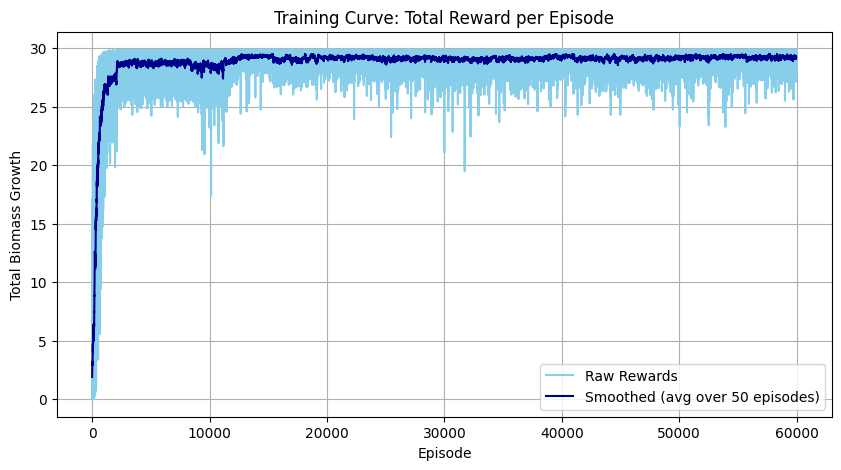

In [25]:
# Moving average to smooth the curve
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(episode_rewards, color='skyblue', label='Raw Rewards')
plt.plot(moving_average(episode_rewards), color='darkblue', label='Smoothed (avg over 50 episodes)')
plt.xlabel("Episode")
plt.ylabel("Total Biomass Growth")
plt.title("Training Curve: Total Reward per Episode")
plt.grid(True)
plt.legend()
plt.show()


In [26]:
import numpy as np

last_episodes = episode_rewards[-200:]
variance = np.var(last_episodes)
print(f"Variance in last 200 episodes: {variance:.3f}")
reward_range = max(last_episodes) - min(last_episodes)
print(f"Range of rewards in last 200 episodes: {reward_range:.2f}")



Variance in last 200 episodes: 0.442
Range of rewards in last 200 episodes: 2.74


In [27]:
# try the random policy to differentiate 
def run_random_policy():
    rewards = []
    state = env.reset()
    for _ in range(env.max_days):
        action = random.randint(0, len(env.action_space)-1)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
    return np.cumsum(rewards)

random_runs = [run_random_policy() for _ in range(3)]




episode 0, Day 1: Action=(-3, -3, -1), Reward=0.001, State=[8112.   24.   54.]
episode 0, Day 2: Action=(-1, -1, 3), Reward=0.002, State=[8111.   23.   57.]
episode 0, Day 3: Action=(-1, -2, 0), Reward=0.006, State=[8110.   21.   57.]
episode 0, Day 4: Action=(-3, 0, 2), Reward=0.006, State=[8107.   21.   59.]
episode 0, Day 5: Action=(-3, 0, 2), Reward=0.007, State=[8104.   21.   61.]
episode 0, Day 6: Action=(3, -2, 0), Reward=0.008, State=[8107.   19.   61.]
episode 0, Day 7: Action=(1, 1, 2), Reward=0.010, State=[8108.   20.   63.]
episode 0, Day 8: Action=(1, 1, 2), Reward=0.010, State=[8109.   21.   65.]
episode 0, Day 9: Action=(1, -2, 3), Reward=0.012, State=[8110.   19.   68.]
episode 0, Day 10: Action=(-3, -3, 3), Reward=0.003, State=[8107.   16.   71.]
episode 0, Day 11: Action=(-3, 3, 3), Reward=0.013, State=[8104.   19.   74.]
episode 0, Day 12: Action=(-2, 3, 2), Reward=0.010, State=[8102.   22.   76.]
episode 0, Day 13: Action=(-2, -2, 2), Reward=0.018, State=[8100.   20

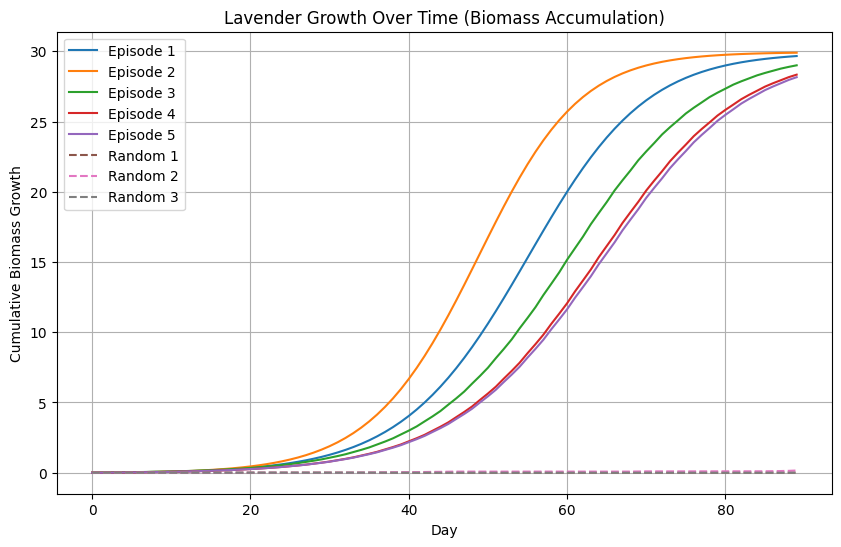

In [28]:

state = env.reset()
state_idx = discretize_state(state)

# print("\nTesting trained agent:")
# total_reward = 0
# for step in range(env.max_days):
#     action = np.argmax(q_table[state_idx])
#     next_state, reward, done, _ = env.step(action)

#     print(f"Day {step+1}: Action={env.action_space[action]}, Reward={reward:.3f}, State={next_state}")
#     total_reward += reward
#     state_idx = discretize_state(next_state)

#     if done:
#         break

# print(f"\nTotal reward (final biomass gain): {total_reward:.2f}")


num_test_episodes = 5
all_rewards = []

for ep in range(num_test_episodes):
    total_reward =0
    state = env.reset()
    state_idx = discretize_state(state)
    episode_rewards = []

    for step in range(env.max_days):
        action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)
        print(f"episode {ep}, Day {step+1}: Action={env.action_space[action]}, Reward={reward:.3f}, State={next_state}")
        total_reward += reward

        episode_rewards.append(reward)
        state_idx = discretize_state(next_state)

        if done:
            print(f"\nTotal reward (final biomass gain): {total_reward:.2f}")

            break

    all_rewards.append(episode_rewards)

# plotting 
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    cumulative = np.cumsum(rewards)
    plt.plot(cumulative, label=f'Episode {i+1}')



# plot on the same plot the random actions it could take 
for i, random_cum in enumerate(random_runs):
    plt.plot(random_cum, linestyle='--', label=f'Random {i+1}')

plt.title('Lavender Growth Over Time (Biomass Accumulation)')
plt.xlabel('Day')
plt.ylabel('Cumulative Biomass Growth')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ppo , offpolicy 